# Emerging Computer Technologies - quantum task

### Try to get familiar with qiskit transpiler

In [70]:
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock.backends import FakeBrooklyn

In [71]:
backend = FakeBrooklyn()
input_path = './original/adder-3.qasm'

In [72]:
def qasmFromPath(input_path, backend):
    qc = QuantumCircuit.from_qasm_file(path=input_path)
    qc_transpiled = transpile(qc, backend=backend)
    filename = './output/test.qasm'
    qc_transpiled.qasm(filename=filename)
    return qc_transpiled

In [73]:
def qasmOptimization(path, backend):
    qc = QuantumCircuit.from_qasm_file(path=path)
    qc_transpiled = []
    for i in range(3):
        qc_transpiled.append(transpile(qc, backend=backend, optimization_level=i))
        filename = './output/test' + str(i) + '.qasm'
        qc_transpiled[i].qasm(filename=filename)
    return qc_transpiled

### Try to get familiar with circuit's representation

This is the input circuit mapped to the 65qubits fake-device with the Transpiler given by qiskit

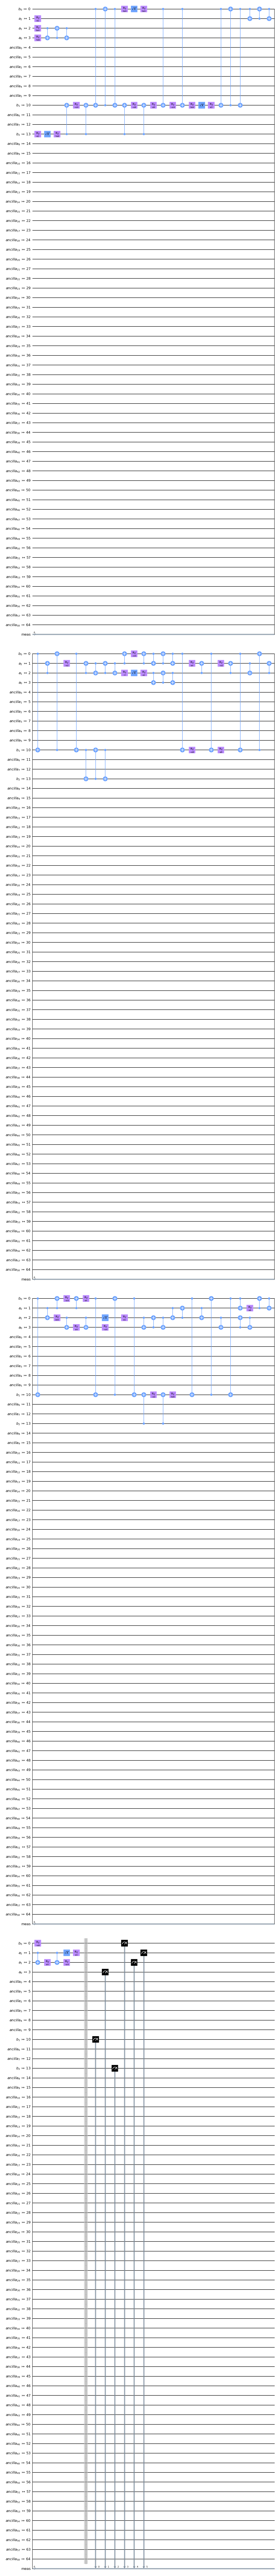

In [74]:
qc_transpiled = qasmFromPath(input_path, backend)
qc_transpiled.draw(output='mpl')

\
\
Let's try to use different kind of transpilers and see the differences in terms of optimization

In [75]:
# TODO try to print several circuits with different optimization
transpilers = qasmOptimization(input_path, backend)
transpilers[0].draw(output='mpl')
for t in transpilers:
    t.draw(output='mpl')

## Try to get familiar with FakeBrooklyn circuit

In [76]:
# take some information on FakeBrooklyn circuit
map = backend.configuration().gates
print(type(map[len(map)-2]))
coupling_list = map[len(map)-2].coupling_map
print('Coupling map -------- \n', type(coupling_list), coupling_list)

print('\n\nBut later I discovered a faster method...\n')
map_easy = backend.configuration().coupling_map
print('coupling easy--', map_easy)

#qubits
num_qubits =  backend.configuration().n_qubits
print('\nnum qubits of device--', num_qubits)

<class 'qiskit.providers.models.backendconfiguration.GateConfig'>
Coupling map -------- 
 <class 'list'> [[0, 1], [0, 10], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 11], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 12], [9, 8], [10, 0], [10, 13], [11, 4], [11, 17], [12, 8], [12, 21], [13, 10], [13, 14], [14, 13], [14, 15], [15, 14], [15, 16], [15, 24], [16, 15], [16, 17], [17, 11], [17, 16], [17, 18], [18, 17], [18, 19], [19, 18], [19, 20], [19, 25], [20, 19], [20, 21], [21, 12], [21, 20], [21, 22], [22, 21], [22, 23], [23, 22], [23, 26], [24, 15], [24, 29], [25, 19], [25, 33], [26, 23], [26, 37], [27, 28], [27, 38], [28, 27], [28, 29], [29, 24], [29, 28], [29, 30], [30, 29], [30, 31], [31, 30], [31, 32], [31, 39], [32, 31], [32, 33], [33, 25], [33, 32], [33, 34], [34, 33], [34, 35], [35, 34], [35, 36], [35, 40], [36, 35], [36, 37], [37, 26], [37, 36], [38, 27], [38, 41], [39, 31], [39, 45], [40, 35], [40, 49], [41, 38], [41, 42], [42, 4

### Understand and use BasicMapper pass (from qiskit)
\
Now I know that I can give an initial_layout like the one described by my device - in practical how many qubits and clbits my final circuit will have. 
\
i.e. The device has 65qubits but the input circuit can have less, so I must **convert the input circuit** (or DAG depending on the representation) **so that it has the same qubits and clbits as the final circuit (the device).**

In [77]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwap(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.

        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.

        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)


        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())
          
        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

## Try to get familiar with DAG from qiskit
\
Let's take a qasm file as input and display his DAG.

QuantumRegister(8, 'a') QuantumRegister(8, 'b')


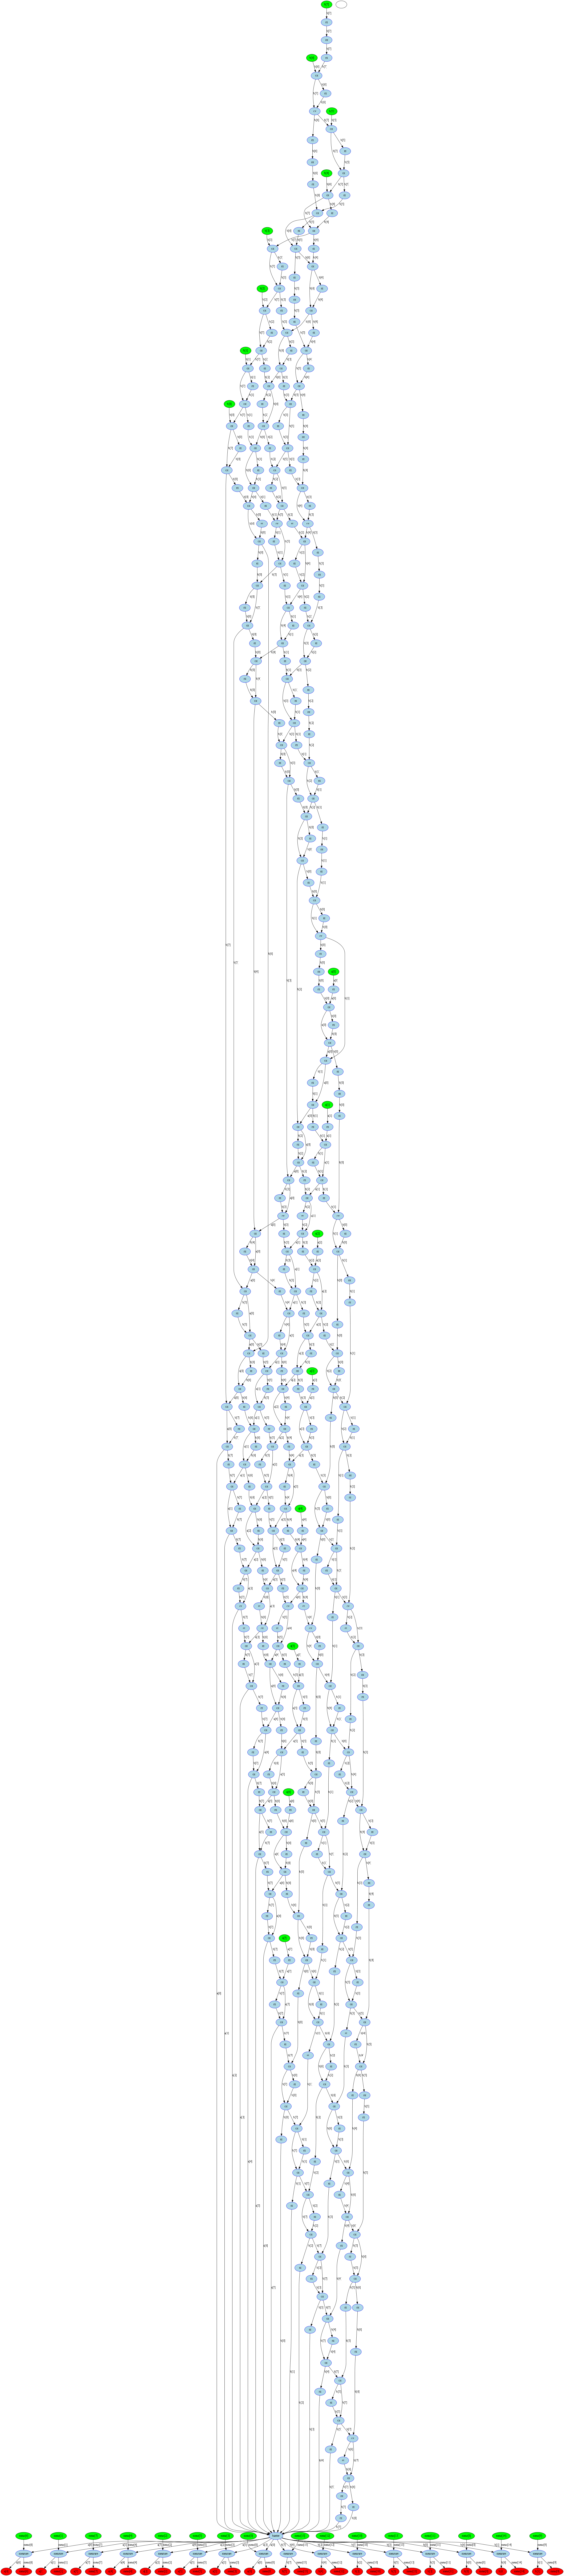

In [78]:
from qiskit.transpiler import CouplingMap
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
from qiskit.dagcircuit import DAGCircuit

%matplotlib inline
input_path = './original/adder-8.qasm'
qc = QuantumCircuit.from_qasm_file(path=input_path)
input_DAG = circuit_to_dag(qc) 
print(*input_DAG.qregs.values())
dag_drawer(input_DAG)

There exists also a representation of the coupling map, and drawing the coupling map of the FakeBrooklyn device you can see how it looks like (i.e. **coupled qubits** in the device)

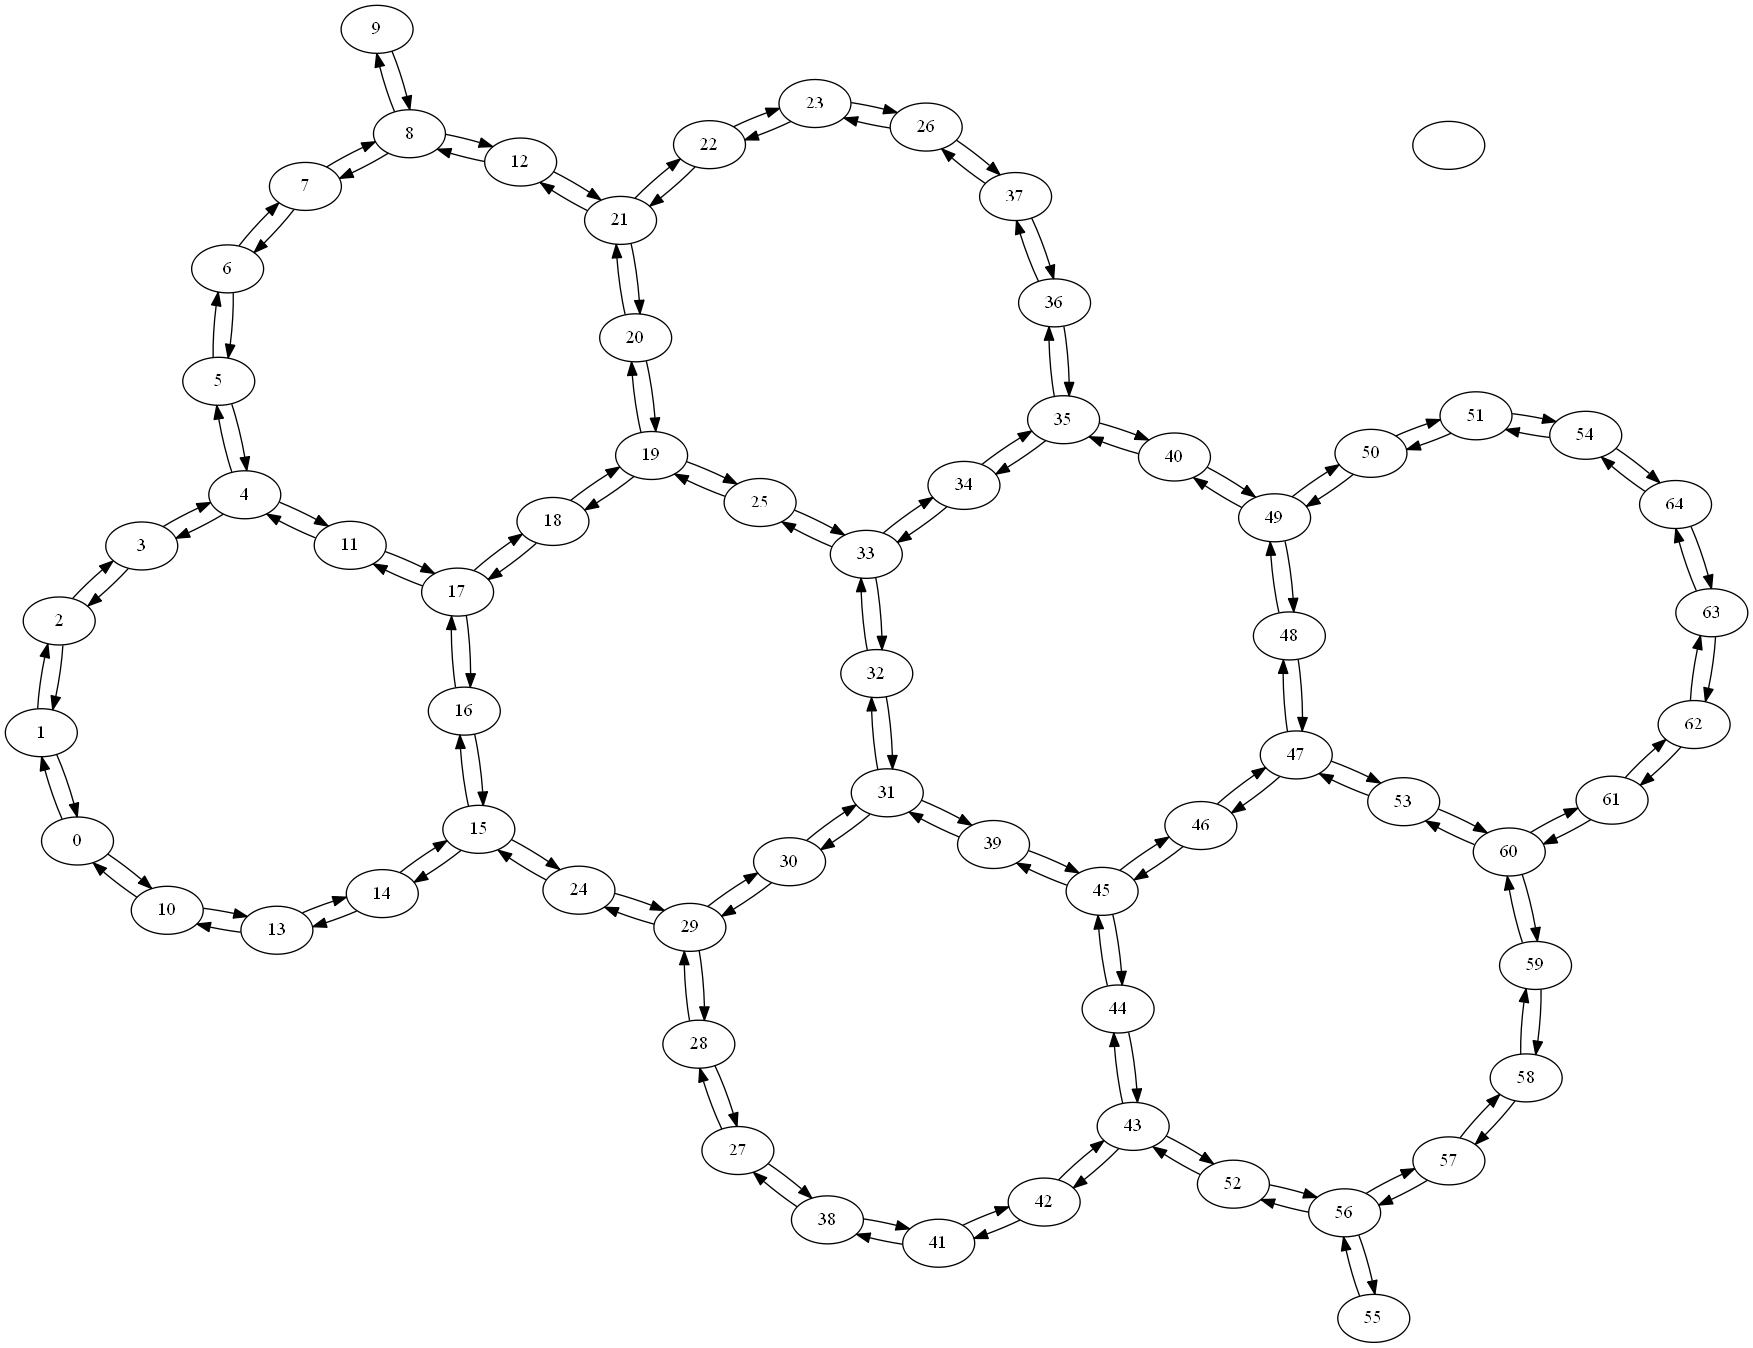

In [79]:
coupling_map = CouplingMap(couplinglist=coupling_list)
coupling_map.draw()

### Let's use the BasicPass!
\
First of all you need to have a DAG of the input circuit that has the same dimension of the device (in terms of qubits and clbits). 
\
Note that a lot of qubits will be unused now, but they can be useful for later optimizations!

In [80]:
from qiskit.transpiler import Layout

# create a circuit the same size as the device, in terms of qubits and clbits
device_qc = QuantumCircuit(num_qubits, num_qubits)
device_DAG = circuit_to_dag(device_qc) 
initial_layout = Layout.generate_trivial_layout(*device_DAG.qregs.values())

#print('qubits--',input_DAG.num_qubits(),input_DAG.num_clbits(), device_DAG.num_qubits(),device_DAG.num_clbits() )
#print(type(device_DAG.qregs.values()))
#print(type(initial_layout))

# build the input_DAG on the device_DAG
device_DAG.compose(input_DAG)
device_DAG.draw(filename='./output/dag_circuit0.jpg')

Now you can **create and run the BasicPass**: it will add **SWAP** gates so that the coupling constraint is satisfied. A lot of gates are added, so we must do subsequent optimizations.
\
Note that the final DAG image is too large, so you have to save it in a file.

In [81]:
basic_pass = BasicSwap(coupling_map, initial_layout)
out_DAG = basic_pass.run(device_DAG)
#out_DAG.draw(filename='./output/dag_circuit.jpg')

And we can also visualize the corresponding **quantum circuit** with the added SWAP.

In [82]:
from qiskit.converters import dag_to_circuit
final_qc = dag_to_circuit(out_DAG)
final_qc.draw()

┌────────────┐                                                      »
 q_0: ┤ Rz(3.1293) ├──────────────────────────────────────────────────────»
      ├───────────┬┘                                                      »
 q_1: ┤ Rz(3.117) ├───────────────────────────────────────────────────────»
      ├───────────┴┐                                                      »
 q_2: ┤ Rz(3.0925) ├──────────────────────────────────────────────────────»
      ├────────────┤                                                      »
 q_3: ┤ Rz(3.0434) ├──────────────────────────────────────────────────────»
      ├────────────┤                                                      »
 q_4: ┤ Rz(15π/16) ├──────────────────────────────────────────────────────»
      └┬──────────┬┘                                                      »
 q_5: ─┤ Rz(7π/8) ├───────────────────────────────────────────────────────»
       ├──────────┤                                                       »
 q_6: ─┤ Rz(3π/4) ├───────────────────────────────────────────────────────»
       ├─────────┬┘                                                       »
 q_7: ─┤ Rz(π/2) ├────────────────────────────────────────────────────────»
       └─────────┘                                                        »
 q_8: ────────────────────────────────────────────────────────────────────»
                                                                          »
 q_9: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_10: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_11: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_12: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_13: ────────────────────────────────────────────────────────────────────»
                                        ┌───┐┌──────────┐┌───┐┌──────────┐»
q_14: ──────────────────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(3π/4) ├»
       ┌─────────┐  ┌────┐┌────────────┐└─┬─┘└──────────┘└─┬─┘└──────────┘»
q_15: ─┤ Rz(π/2) ├──┤ √X ├┤ Rz(3.1293) ├──■────────────────■──────────────»
       └─────────┘  └────┘└────────────┘                                  »
q_16: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_17: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_18: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_19: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_20: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_21: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_22: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_23: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_24: ────────────────────────────────────────────────────────────────────»
                                                                          »
q_25: ────────────────────────────────────────────────────────────────────»
                                                      

# Define costs of gates

In [83]:
RZ = 0
X = 1
SX = 1
CNOT = 10
SWAP = 30

In [84]:
def compute_cost(dag_circuit):
    gates = {'rz': 0, 'rx': 0, 'sx': 0, 'cx': 0, 'swap': 0}
    count_ops = dag_circuit.count_ops()
    gates.update(count_ops)
    print('gates---\n',gates)
    
    #for this project only these costs are assigned
    rz_cost = RZ * gates['rz']
    x_cost = X * gates['rx']
    sx_cost = SX * gates['sx']
    cnot_cost = CNOT * gates['cx']
    swap_cost = SWAP * gates['swap']
    
    total_cost = rz_cost + x_cost + sx_cost + cnot_cost + swap_cost
    return total_cost

### Let's try the function with our initial mapped circuit:

In [85]:
first_cost = print('\n\nfirst cost of the circuit:',compute_cost(out_DAG))

gates---
 {'rz': 209, 'rx': 0, 'sx': 16, 'cx': 184, 'swap': 284, 'barrier': 1, 'measure': 16}


first cost of the circuit: 10376


### Too high isn't it? We must make optimizations! ------------------------

In [86]:
qc.draw()

┌────────────┐                                                      »
    a_0: ┤ Rz(3.1293) ├──────────────────────────────────────────────────────»
         ├───────────┬┘                                                      »
    a_1: ┤ Rz(3.117) ├───────────────────────────────────────────────────────»
         ├───────────┴┐                                                      »
    a_2: ┤ Rz(3.0925) ├──────────────────────────────────────────────────────»
         ├────────────┤                                                      »
    a_3: ┤ Rz(3.0434) ├──────────────────────────────────────────────────────»
         ├────────────┤                                                      »
    a_4: ┤ Rz(15π/16) ├──────────────────────────────────────────────────────»
         └┬──────────┬┘                                                      »
    a_5: ─┤ Rz(7π/8) ├───────────────────────────────────────────────────────»
          ├──────────┤                                                       »
    a_6: ─┤ Rz(3π/4) ├───────────────────────────────────────────────────────»
          ├─────────┬┘                                                       »
    a_7: ─┤ Rz(π/2) ├────────────────────────────────────────────────────────»
          └─────────┘                                                        »
    b_0: ────────────────────────────────────────────────────────────────────»
                                                                             »
    b_1: ────────────────────────────────────────────────────────────────────»
                                                                             »
    b_2: ────────────────────────────────────────────────────────────────────»
                                                                             »
    b_3: ────────────────────────────────────────────────────────────────────»
                                                                             »
    b_4: ────────────────────────────────────────────────────────────────────»
                                                                             »
    b_5: ────────────────────────────────────────────────────────────────────»
                                           ┌───┐┌──────────┐┌───┐┌──────────┐»
    b_6: ──────────────────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(3π/4) ├»
          ┌─────────┐  ┌────┐┌────────────┐└─┬─┘└──────────┘└─┬─┘└──────────┘»
    b_7: ─┤ Rz(π/2) ├──┤ √X ├┤ Rz(3.1293) ├──■────────────────■──────────────»
          └─────────┘  └────┘└────────────┘                                  »
meas: 16/════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                                         »
«    a_0: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_1: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_2: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_3: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_4: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_5: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_6: ────────────────────────────────────────────────────────────────»
«                                                                         »
«    a_7: ────────────────────────────────────────────────────────────────»
«                           

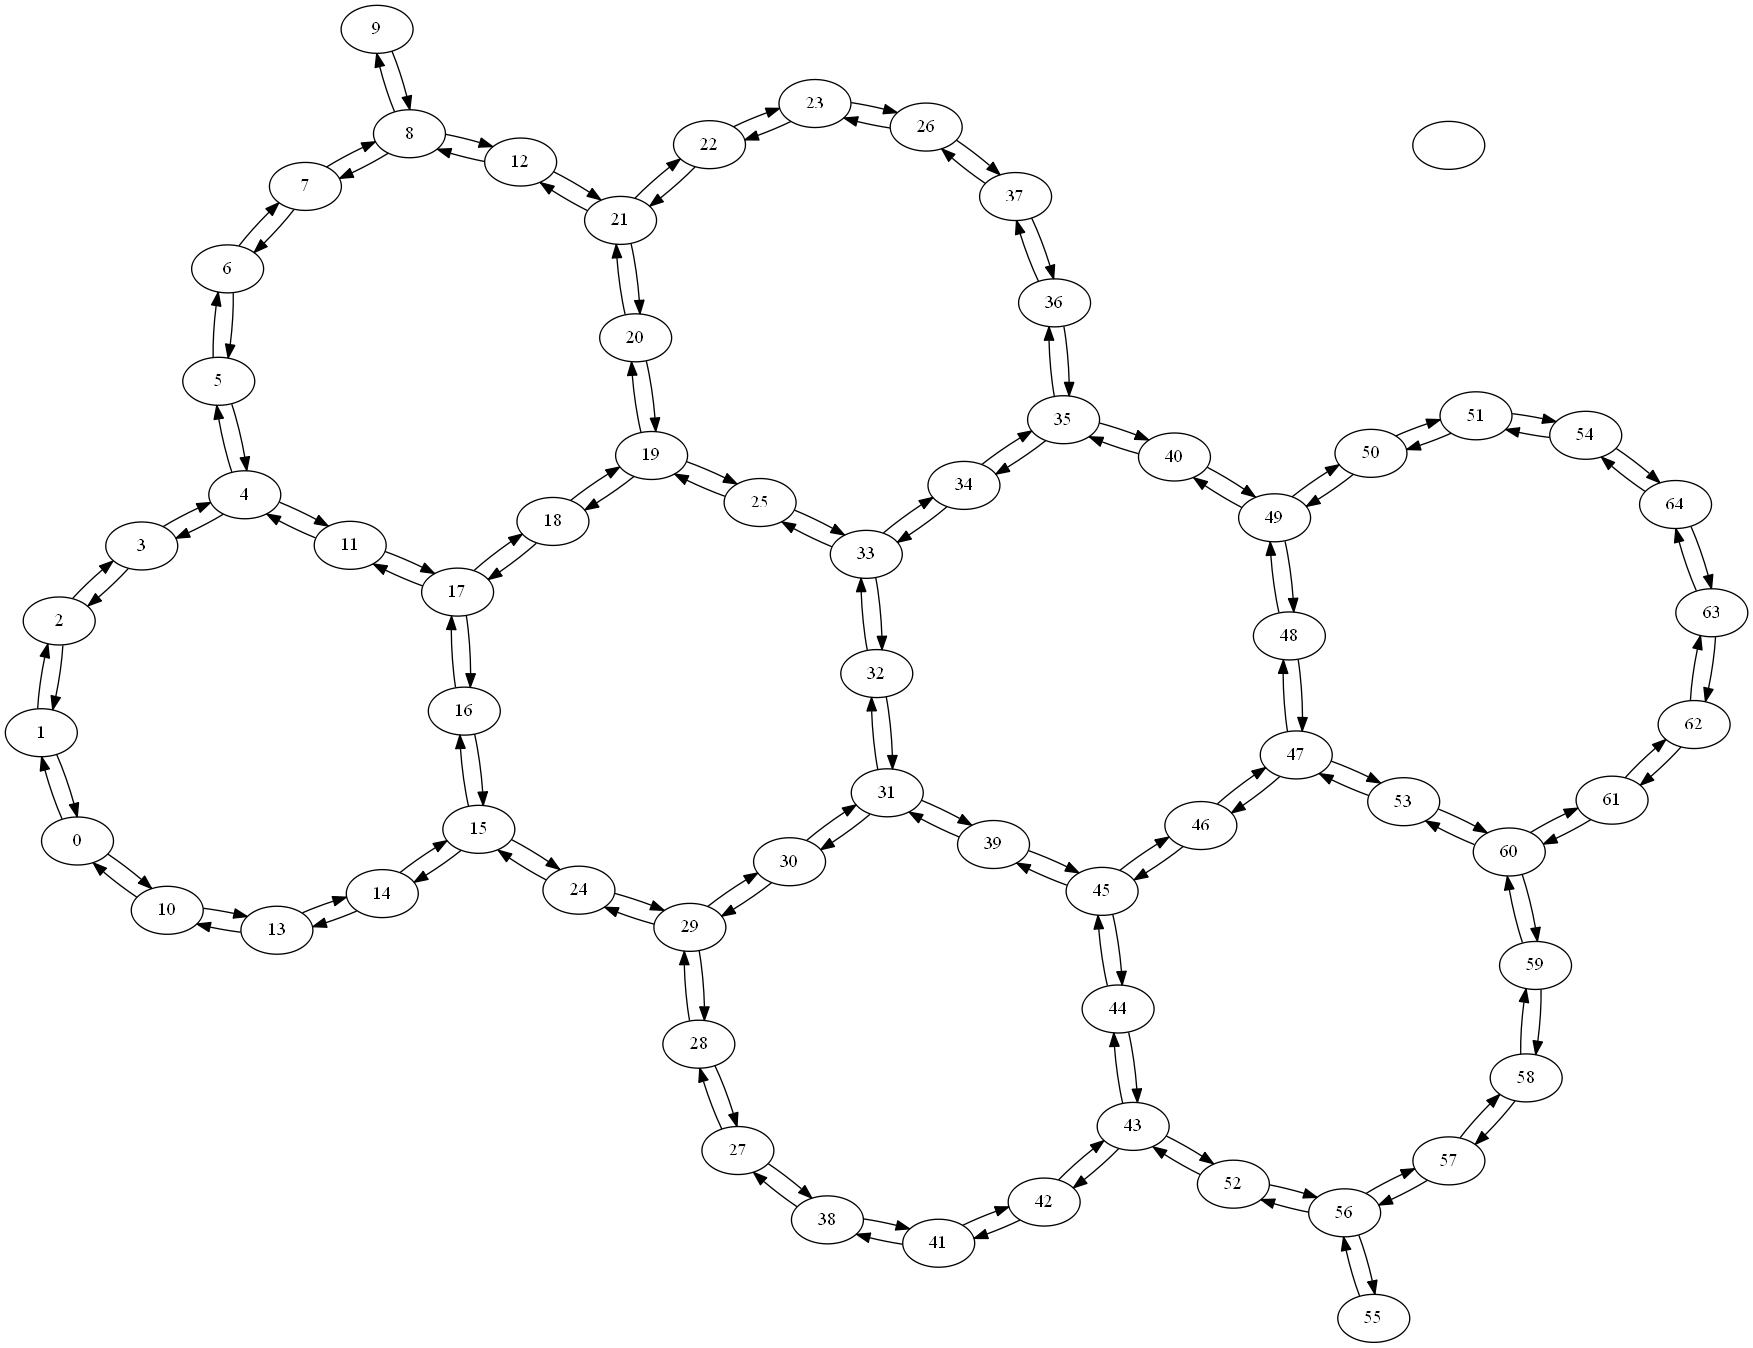

In [87]:
coupling_map.draw()

In [88]:
from qiskit.transpiler import TranspilerError
import random

class topologicalAssignment():
    
    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout
        
    def run(self, dag):
        
        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())
          
        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()
        
        """
        dic = current_layout.get_physical_bits()
        temp = dic[1]
        dic[1] = dic[15]
        dic[15] = temp
        new_layout = Layout(dic)
        print(new_layout.get_virtual_bits())
        """
        
        #initialize layout dictionary
        #keys --> virtual, values --> physical
        # layout_dict[virtual_qbit] to access the physical
        # list(layour_dict.values()) to retrieve the physical qubits used
        layer_dict = trivial_layout.copy().get_virtual_bits() 
        
        
        for key in layer_dict.keys():
            layer_dict[key] = None
        print(layer_dict)
        new_DAG = DAGCircuit()
        
        i = 31 #starting qubit => it has a lot of coupling
        for layer in dag.serial_layers():
            subdag = layer['graph']
            for gate in subdag.two_qubit_ops():
                # gate defines a two qubits op with virtual qubits gate.qargs[0] and gate.qargs[1]
                
                if layer_dict[gate.qargs[0]] == None: #physical qubit not associated yet
                    layer_dict[gate.qargs[0]] = i
                    
                if layer_dict[gate.qargs[1]] == None: #physical qubit not associated yet
                    physical_q0 = layer_dict[gate.qargs[0]] 
                    assigned = False
                    physical_assigned = list(filter(None,layer_dict.values()))

                    for n in self.coupling_map.neighbors(physical_q0): #take all the qubits adjacent to q0
                        print(n)
                        if n not in physical_assigned:
                            layer_dict[gate.qargs[1]] = n
                            assigned = True
                            break
                    
                    distance_q0 = self.coupling_map.distance_matrix[physical_q0].copy()
                    print(distance_q0)
                    for i in range(1, int(distance_q0.max()) + 1):  #let i as close as possible to q0
                        candidates = [index for index, element in enumerate(distance_q0) if element == i] #element is the distance from q0
                        random.shuffle(candidates)
                        for n in candidates: #search in the nearest qubits wrt q0
                            print(n)
                            if n not in physical_assigned:
                                layer_dict[gate.qargs[1]] = n
                                print('\n\n assigned to:', n)
                                assigned = True
                                break
                        if assigned == True:
                            break
                            
                    if assigned == False:
                        raise TranspilerError('The layout does not match the amount of qubits in the DAG')                    
                    
                physical_assigned = list(layer_dict.values()) 
                while i in physical_assigned:  #let i as close as possible to the previous qubits
                    i += 1
                    if i == 65:
                        i = 0
                    
        print("this is \n\n\n\n",layer_dict)
        
        # map all the unused qubits
        used = list(filter(None,layer_dict.values()))
        total = list(range(0, 65))
        unused = [x for x in total if x not in used]
        
        for virtual in layer_dict.keys():
            if layer_dict[virtual] == None:
                layer_dict[virtual] = unused[0]
                unused.pop(0)
        
        #check
        physical = set(layer_dict.values())
        print('\n\nNum of physical unique qubit assigned: --',len(physical))
        
        layout = Layout(layer_dict)
        #print('\n\n',layout.get_physical_bits())
        return layout
            
tp = topologicalAssignment(coupling_map, initial_layout)
tp_layout = tp.run(device_DAG)
print(tp_layout)

{Qubit(QuantumRegister(65, 'q'), 0): None, Qubit(QuantumRegister(65, 'q'), 1): None, Qubit(QuantumRegister(65, 'q'), 2): None, Qubit(QuantumRegister(65, 'q'), 3): None, Qubit(QuantumRegister(65, 'q'), 4): None, Qubit(QuantumRegister(65, 'q'), 5): None, Qubit(QuantumRegister(65, 'q'), 6): None, Qubit(QuantumRegister(65, 'q'), 7): None, Qubit(QuantumRegister(65, 'q'), 8): None, Qubit(QuantumRegister(65, 'q'), 9): None, Qubit(QuantumRegister(65, 'q'), 10): None, Qubit(QuantumRegister(65, 'q'), 11): None, Qubit(QuantumRegister(65, 'q'), 12): None, Qubit(QuantumRegister(65, 'q'), 13): None, Qubit(QuantumRegister(65, 'q'), 14): None, Qubit(QuantumRegister(65, 'q'), 15): None, Qubit(QuantumRegister(65, 'q'), 16): None, Qubit(QuantumRegister(65, 'q'), 17): None, Qubit(QuantumRegister(65, 'q'), 18): None, Qubit(QuantumRegister(65, 'q'), 19): None, Qubit(QuantumRegister(65, 'q'), 20): None, Qubit(QuantumRegister(65, 'q'), 21): None, Qubit(QuantumRegister(65, 'q'), 22): None, Qubit(QuantumRegiste

In [89]:
print(initial_layout)

Layout({
0: Qubit(QuantumRegister(65, 'q'), 0),
1: Qubit(QuantumRegister(65, 'q'), 1),
2: Qubit(QuantumRegister(65, 'q'), 2),
3: Qubit(QuantumRegister(65, 'q'), 3),
4: Qubit(QuantumRegister(65, 'q'), 4),
5: Qubit(QuantumRegister(65, 'q'), 5),
6: Qubit(QuantumRegister(65, 'q'), 6),
7: Qubit(QuantumRegister(65, 'q'), 7),
8: Qubit(QuantumRegister(65, 'q'), 8),
9: Qubit(QuantumRegister(65, 'q'), 9),
10: Qubit(QuantumRegister(65, 'q'), 10),
11: Qubit(QuantumRegister(65, 'q'), 11),
12: Qubit(QuantumRegister(65, 'q'), 12),
13: Qubit(QuantumRegister(65, 'q'), 13),
14: Qubit(QuantumRegister(65, 'q'), 14),
15: Qubit(QuantumRegister(65, 'q'), 15),
16: Qubit(QuantumRegister(65, 'q'), 16),
17: Qubit(QuantumRegister(65, 'q'), 17),
18: Qubit(QuantumRegister(65, 'q'), 18),
19: Qubit(QuantumRegister(65, 'q'), 19),
20: Qubit(QuantumRegister(65, 'q'), 20),
21: Qubit(QuantumRegister(65, 'q'), 21),
22: Qubit(QuantumRegister(65, 'q'), 22),
23: Qubit(QuantumRegister(65, 'q'), 23),
24: Qubit(QuantumRegister(6

In [90]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate


class BasicSwapModified(TransformationPass):
    """Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates."""

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """Maps a DAGCircuit onto a `coupling_map` using swap gates.

        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout
        print('\n\ninitial layout-----', self.initial_layout)

    def run(self, dag):
        """Runs the BasicSwap pass on `dag`.

        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG.
        """
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)


        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())
       
        if len(dag.qubits) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        canonical_register = dag.qregs['q']
        #trivial_layout = Layout.generate_trivial_layout(canonical_register)
        #current_layout = trivial_layout.copy()
        current_layout = self.initial_layout.copy()
        print('\n\ncurrent layout\n-----------', current_layout)
        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

        return new_dag

In [91]:
basic_pass2 = BasicSwapModified(coupling_map, tp_layout)
out_DAG2 = basic_pass2.run(device_DAG)




initial layout----- Layout({
3: Qubit(QuantumRegister(65, 'q'), 0),
4: Qubit(QuantumRegister(65, 'q'), 1),
5: Qubit(QuantumRegister(65, 'q'), 2),
6: Qubit(QuantumRegister(65, 'q'), 3),
7: Qubit(QuantumRegister(65, 'q'), 4),
8: Qubit(QuantumRegister(65, 'q'), 5),
9: Qubit(QuantumRegister(65, 'q'), 6),
10: Qubit(QuantumRegister(65, 'q'), 7),
28: Qubit(QuantumRegister(65, 'q'), 8),
33: Qubit(QuantumRegister(65, 'q'), 9),
45: Qubit(QuantumRegister(65, 'q'), 10),
29: Qubit(QuantumRegister(65, 'q'), 11),
30: Qubit(QuantumRegister(65, 'q'), 12),
39: Qubit(QuantumRegister(65, 'q'), 13),
32: Qubit(QuantumRegister(65, 'q'), 14),
31: Qubit(QuantumRegister(65, 'q'), 15),
0: Qubit(QuantumRegister(65, 'q'), 16),
1: Qubit(QuantumRegister(65, 'q'), 17),
2: Qubit(QuantumRegister(65, 'q'), 18),
11: Qubit(QuantumRegister(65, 'q'), 19),
12: Qubit(QuantumRegister(65, 'q'), 20),
13: Qubit(QuantumRegister(65, 'q'), 21),
14: Qubit(QuantumRegister(65, 'q'), 22),
15: Qubit(QuantumRegister(65, 'q'), 23),
16: Q

In [92]:
out_DAG2.draw(filename='./output/dag_circuit1.png')

In [93]:
cost2 = compute_cost(out_DAG2)
second_cost = print('\n\nsecond cost of the circuit:',cost2)

gates---
 {'rz': 209, 'rx': 0, 'sx': 16, 'cx': 184, 'swap': 203, 'barrier': 1, 'measure': 16}


second cost of the circuit: 7946


### try with a smaller network

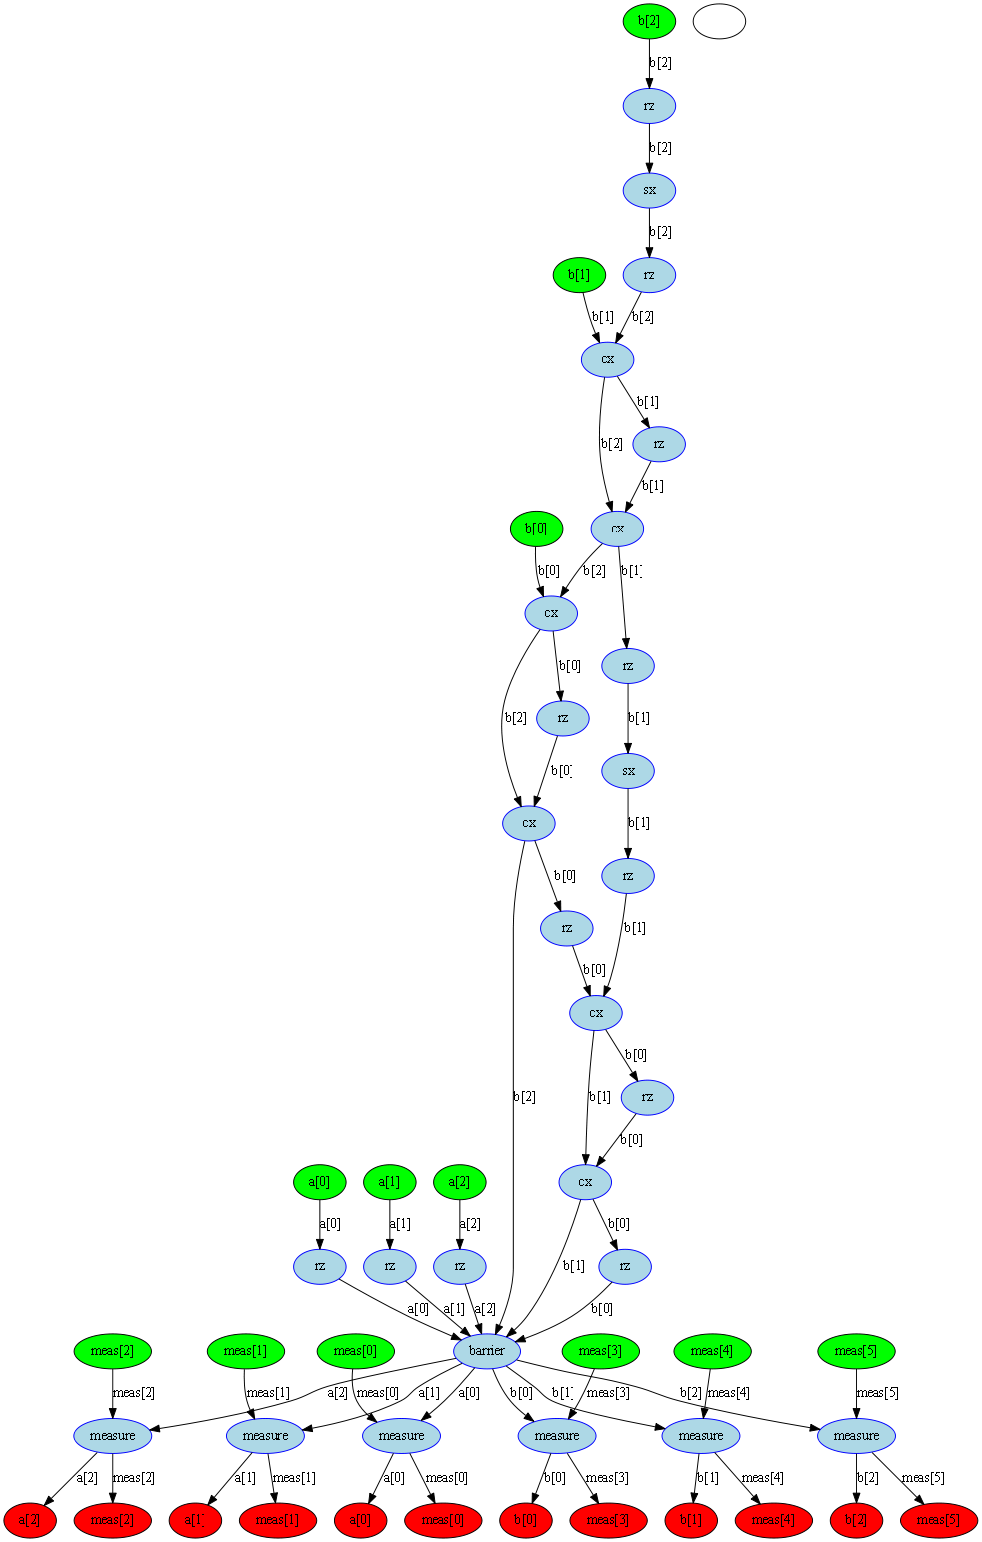

In [94]:
input_path = './original/test.qasm'
qc = QuantumCircuit.from_qasm_file(path=input_path)
input_DAG = circuit_to_dag(qc) 
dag_drawer(input_DAG)

In [95]:
from qiskit.transpiler import Layout

# create a circuit the same size as the device, in terms of qubits and clbits
device_qc = QuantumCircuit(num_qubits, num_qubits)
device_DAG = circuit_to_dag(device_qc) 
initial_layout = Layout.generate_trivial_layout(*device_DAG.qregs.values())

#print('qubits--',input_DAG.num_qubits(),input_DAG.num_clbits(), device_DAG.num_qubits(),device_DAG.num_clbits() )
#print(type(device_DAG.qregs.values()))
#print(type(initial_layout))

# build the input_DAG on the device_DAG
device_DAG.compose(input_DAG)
basic_pass = BasicSwap(coupling_map, initial_layout)
out_DAG = basic_pass.run(device_DAG)
test_cost = print('\n\test cost of the circuit:',compute_cost(out_DAG))
dag_drawer(out_DAG)
out_DAG.draw(filename='./output/dag_circuit3.png')
#out_DAG.draw(filename='./output/dag_circuit.jpg')

gates---
 {'rz': 12, 'rx': 0, 'sx': 2, 'cx': 6, 'swap': 2, 'barrier': 1, 'measure': 6}

	est cost of the circuit: 122


{Qubit(QuantumRegister(65, 'q'), 0): None, Qubit(QuantumRegister(65, 'q'), 1): None, Qubit(QuantumRegister(65, 'q'), 2): None, Qubit(QuantumRegister(65, 'q'), 3): None, Qubit(QuantumRegister(65, 'q'), 4): None, Qubit(QuantumRegister(65, 'q'), 5): None, Qubit(QuantumRegister(65, 'q'), 6): None, Qubit(QuantumRegister(65, 'q'), 7): None, Qubit(QuantumRegister(65, 'q'), 8): None, Qubit(QuantumRegister(65, 'q'), 9): None, Qubit(QuantumRegister(65, 'q'), 10): None, Qubit(QuantumRegister(65, 'q'), 11): None, Qubit(QuantumRegister(65, 'q'), 12): None, Qubit(QuantumRegister(65, 'q'), 13): None, Qubit(QuantumRegister(65, 'q'), 14): None, Qubit(QuantumRegister(65, 'q'), 15): None, Qubit(QuantumRegister(65, 'q'), 16): None, Qubit(QuantumRegister(65, 'q'), 17): None, Qubit(QuantumRegister(65, 'q'), 18): None, Qubit(QuantumRegister(65, 'q'), 19): None, Qubit(QuantumRegister(65, 'q'), 20): None, Qubit(QuantumRegister(65, 'q'), 21): None, Qubit(QuantumRegister(65, 'q'), 22): None, Qubit(QuantumRegiste

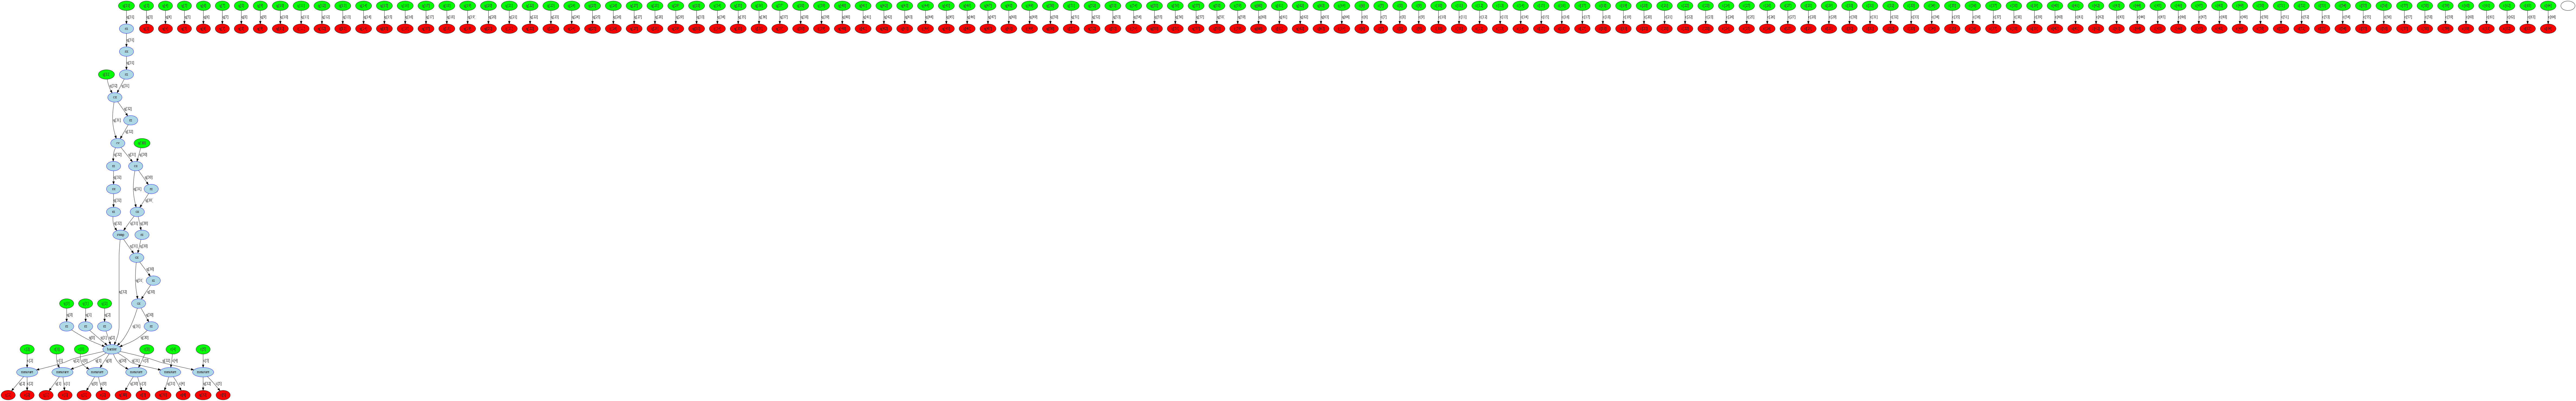

In [96]:
tp_test = topologicalAssignment(coupling_map, initial_layout)
tp_layout_test = tp_test.run(device_DAG)
print('\n\n out of layout.------------\n',tp_layout_test)
basic_pass_test2 = BasicSwapModified(coupling_map, tp_layout_test)
dag_test2 = basic_pass_test2.run(device_DAG)
test_cost2 = compute_cost(dag_test2)
print('\n\test cost of the circuit:',test_cost2)
dag_test2.draw(filename='./output/dag_circuit4.png')
dag_drawer(dag_test2)

In [97]:
count_ops = dag_test2.count_ops()
gates = {'rz': 0, 'rx': 0, 'sx': 0, 'cx': 0, 'swap': 0}
gates.update(count_ops)
print('gates---\n',gates)
test_cost2 = compute_cost(dag_test2)
print('\n\ntest cost of the circuit:',test_cost2)

gates---
 {'rz': 12, 'rx': 0, 'sx': 2, 'cx': 6, 'swap': 1, 'barrier': 1, 'measure': 6}
gates---
 {'rz': 12, 'rx': 0, 'sx': 2, 'cx': 6, 'swap': 1, 'barrier': 1, 'measure': 6}


test cost of the circuit: 92
